## Ahmad Hojatimalekshah

### Collaborate: Arash Modaresi, Amir Kazemzadeh, Ali Nazari
### The collaboration was on question 7

## Final EXAM

### Load libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import norm, multivariate_normal
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn import model_selection, metrics, datasets, svm
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

# 1.

### Read the data

In [2]:
data = pd.read_csv('data_mvnorm2mix.csv')
X = np.array(data)

### Plot the data

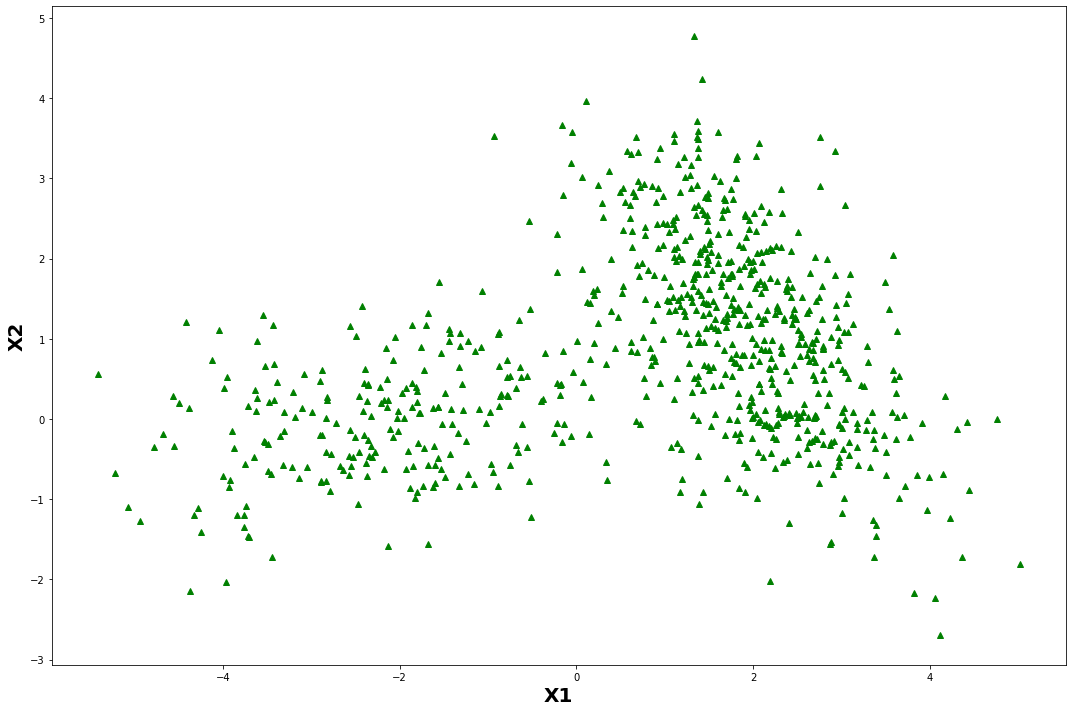

In [3]:
fig = plt.figure(figsize = (15,10))
plt.plot(X[:, 0], X[:, 1], 'g^')
plt.xlabel('X1',weight='bold',fontsize=20)
plt.ylabel('X2',weight='bold',fontsize=20)
plt.tight_layout()

### Gaussian Mixture Model

In [4]:
def GMM(X,p,mu1,mu2,sgma1,sgma2,nitr):
    resp = np.zeros((len(X), 2))
    log_likelihood = np.zeros((nitr, 1))
    for i in range(nitr):
        f = p[0]*multivariate_normal(mu1,sgma1).pdf(X)+p[1]*multivariate_normal(mu2,sgma2).pdf(X)
        z1 = (p[0])*multivariate_normal(mu1,sgma1).pdf(X)/f
        z2 = (p[1])*multivariate_normal(mu2,sgma2).pdf(X)/f
        p[0] = sum(z1)/len(X)
        p[1] = sum(z2)/len(X)
        mu1 = np.dot(z1.T,X)/sum(z1)
        mu2 = np.dot(z2.T,X)/sum(z2)
        sgma1 = np.dot(z1*(X-mu1).T,(X-mu1))/sum(z1)
        sgma2 = np.dot(z2*(X-mu2).T,(X-mu2))/sum(z2)
        resp[:, 0] = p[0] * multivariate_normal(mu1, sgma1).pdf(X)
        resp[:, 1] = p[1] * multivariate_normal(mu2, sgma2).pdf(X)    
        log_likelihood[i] = np.sum(np.log(np.sum(resp, axis = 1)))
    return p,mu1,mu2,sgma1,sgma2,log_likelihood 

# (a)

### Initial Values

In [5]:
p = np.array([0.25,0.75])
mu1 = np.array([-1,1])
mu2 = np.array([4,5])
sgma1 = np.array([[5,.3],[.3,3.5]])
sgma2 = np.array([[0.8,-.5],[-.5,1.5]])

p,mu1,mu2,sgma1,sgma2, log_likelihood = GMM(X,p,mu1,mu2,sgma1,sgma2,100)

### Maximum Likelihood Estimation of the parameters

In [6]:
print('MLE of p:',p)
print('MLE of the first mean:',mu1)
print('MLE of the second mean:',mu2)

print('MLE of the first standard deviation:')
sgma1

print('MLE of the second standard deviation:')
sgma2

MLE of p: [0.30812007 0.69187993]
MLE of the first mean: [-2.0044957   0.02217512]
MLE of the second mean: [1.97673277 1.15430445]
MLE of the first standard deviation:
MLE of the second standard deviation:


array([[ 0.84339551, -0.66309604],
       [-0.66309604,  1.50319884]])

### Lets find the classes by the estimated parameters

In [7]:
resp1 = p[0]*multivariate_normal(mu1, sgma1).pdf(X)
resp2 = p[1]*multivariate_normal(mu2, sgma2).pdf(X)
u = resp1/resp2
class1 = X[np.where(u<1)]
class2 = X[np.where(u>=1)]

### Plotting the classification results

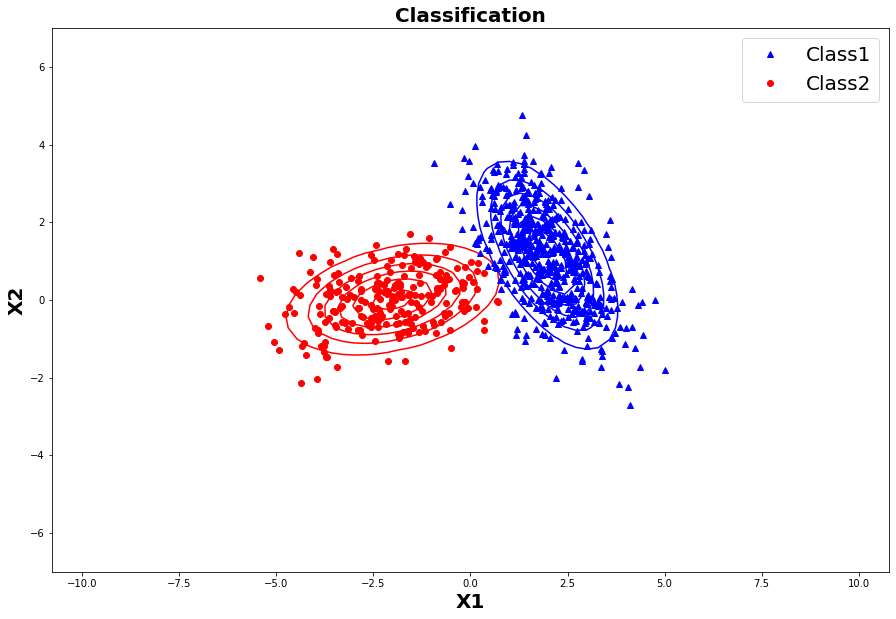

In [8]:
plt.figure(figsize=(15,10))
plt.plot(class1[:,0],class1[:,1], 'b^')
plt.plot(class2[:,0],class2[:,1], 'ro')
plt.axis('equal')
plt.xlabel('X1',weight='bold',fontsize=20)
plt.ylabel('X2',weight='bold',fontsize=20)
plt.title('Classification',weight='bold',fontsize=20)
plt.legend(['Class1','Class2'],fontsize=20)

x, y = np.meshgrid(np.linspace(-7, 7), np.linspace(-7,7))
t = np.column_stack((x.reshape(len(x)**2,1),y.reshape(len(y)**2,1)))
f1 = multivariate_normal(mu1,sgma1).pdf(t)
f2 = multivariate_normal(mu2,sgma2).pdf(t)
z1 = f1.reshape((len(x),len(x)))
z2 = f2.reshape((len(x),len(x)))
plt.contour(x, y, z1,linewidths=1.5, colors='r')
plt.contour(x, y, z2,linewidths=1.5, colors='b')
plt.show()

# 2.

### Load the data

In [9]:
data=pd.read_csv('data_snow_tree.csv')
data.head()

,VZmax,VPzabove1,VPzabove3,VPzabove4,VZq90,VZq95,VFHD,VSlope,VAspect,Depth
0,20.200,99.752129,88.107317,81.332597,15.9854,17.2050,2.536217,17.752318,172.106556,0.607861
1,9.410,97.875464,59.896416,43.401041,6.5660,7.3340,2.008234,1.222789,169.351610,1.000316
2,19.564,99.810375,96.153325,84.653935,17.2290,17.8950,2.255792,2.839515,166.139445,0.884730
3,14.431,97.085151,59.967064,41.881313,7.4800,8.3000,1.568804,22.447919,310.658943,0.948709
4,25.519,99.001252,73.539449,66.172511,18.1640,20.3701,3.031498,15.289915,161.095405,0.691791


As the snow depth is continuous data, we assign class labels to the snow depth by average depth increase and make binary class.

In [10]:
y = np.array(data['Depth'])
X = np.array(data.iloc[:,:9])

In [11]:
cls = y>np.mean(y)
y = cls*1

### Standardizing the features value

In [12]:
X_std = StandardScaler().fit_transform(X)

### Feature Importance with forests of trees

#### Mean decrease impurity

Feature ranking:
1. feature VZmax (0.138479)
2. feature VZq95 (0.124037)
3. feature VZq90 (0.121860)
4. feature VPzabove4 (0.107653)
5. feature VPzabove1 (0.107287)
6. feature VFHD (0.102611)
7. feature VAspect (0.102163)
8. feature VPzabove3 (0.099955)
9. feature VSlope (0.095955)


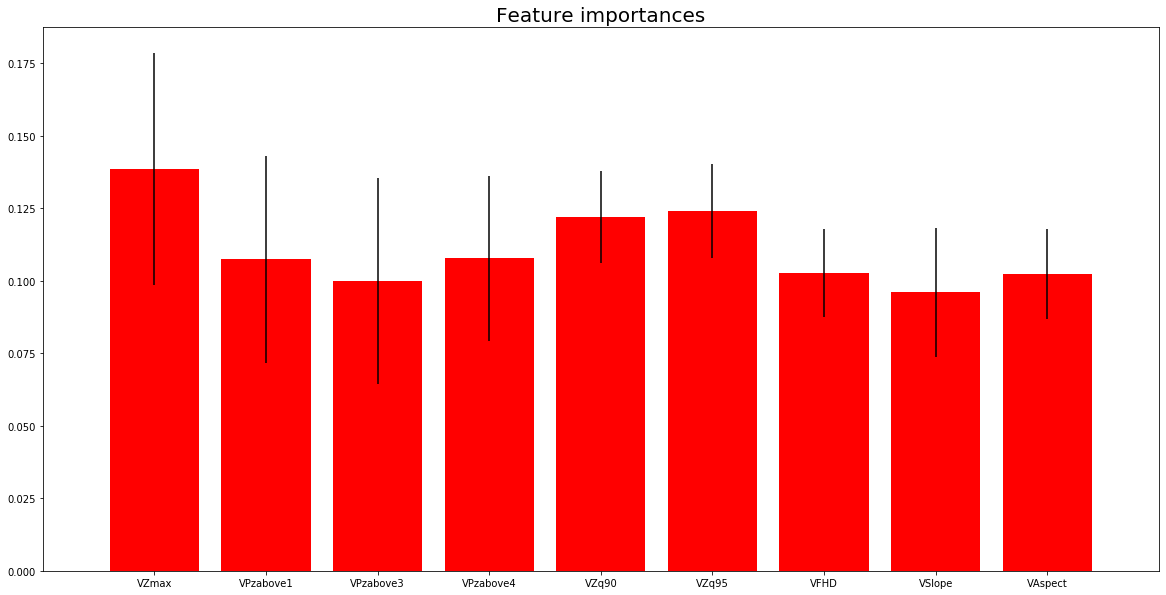

In [13]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=1234)

forest.fit(X_std, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

names = list(data.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_std.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances",fontsize=20)
plt.bar(names[0:-1], importances,color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_std.shape[1]), names[indices])
plt.xlim([-1, X_std.shape[1]])
plt.show()

**Explain why this technique is important?**

Feature importance is important in a model prediction and provides insight into the data, the model, and is the basis for dimensionality reduction and feature selection that can improve the efficiency of a model prediction. In case we have dependent features we can apply PCA on those datasets to have independent features and use the transformed data (reduced features) in modeling but PCA does not show which of those original features are more effective in our estimation.

There are a few things to keep in mind when using the impurity based ranking. Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories. Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

# 3.

### Logistic Regression Feature Importance

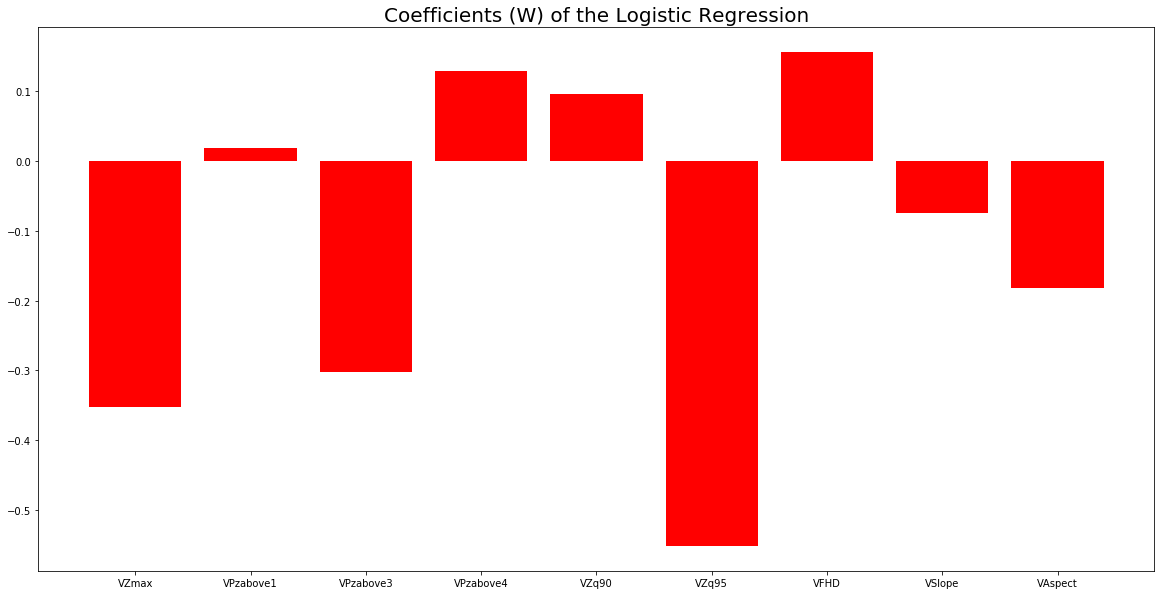

In [14]:
# List of feature names 
names = list(data.columns)

# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['Depth'], axis=1),y,test_size=0.3,random_state=1234)

# Standardize the data
X_std = StandardScaler().fit_transform(X_train)

# logistic regression fit with Ridge regularisation
lg = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
lg.fit(X_std, y_train)

# Coefficients
importance = lg.estimator_.coef_[0]

# plot feature importance
plt.figure(figsize=(20,10))
plt.title("Coefficients (W) of the Logistic Regression",fontsize=20)
plt.bar(names[0:-1], importance, color='r')
plt.show()

Random Forest works well for nonlinear cases, but in logistic regression we need to have linear model.
Correlated features in Random Forest will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts. RF and Logistic Regression methods result are different for feature importance and that's because our data features are highly correlated. 

# 4.

For oversampling the imbalanced datasets we can use Markov Chain sampling methods like Rejection Sampling, in which we need to define an envelope that totaly covers the target distribution and generate samples from known envelope distribution and keep those below the target probability distribution function. Another method would be Sampling Importance Resampling (SIR) method in which First, a sample is drawn from a proposal distribution and then from this a smaller sample is drawn with sample probabilities proportional to the importance ratios. In both cases the target distribution function should be available then we need to use another oversampling technique.
However, the method I used here is an oversampling method called Synthetic Minority Oversampling Technique (SMOTE). SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [15]:
iris = load_iris()
X = iris.data
y = iris.target 
y[y != 0]=1    # Iris-Setosa vs. others
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

### Nearest Neighbor function

In [16]:
def nearest_neighbour(X):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    weight = np.random.uniform(low=0.001, high=1.0, size=X.shape[0])
    additive = distances[:,1]*weight
    return additive

### Synthetic Minority Oversampling TEchnique (SMOTE) function

In [17]:
def SMOTE(X,y):
    # finding the lables and the shape of the classes
    unique, counts = np.unique(y, return_counts=True)
    
    # which class is the minority
    r = np.where(counts == np.min(counts))
    
    # The number of Majority and Minority classes
    minority_count = dict(zip(unique, counts))[0]
    majority_count = dict(zip(unique, counts))[1]
    
    # Separating the minority class for further analysis
    x = X[y==r[0]]
       
    # ratio and remainder of the number of majority over minority classs 
    n = majority_count//minority_count
    m = majority_count%minority_count
    
    # Zeros matrix for the results
    X_n = np.zeros(((n-1)*minority_count,x.shape[1]))
    
    for i in range(n-1):
        X_n[i*minority_count:(i+1)*minority_count,:] = (x + nearest_neighbour(x).reshape(len(x),1))
    
    # If we have remainder
    if m != 0:
        rows = random.sample(range(0, len(x)), m)
        X_m =  x[rows,:] + nearest_neighbour(x[rows,:]).reshape(len(x[rows,:]),1)
        X_n = np.concatenate((X_n, X_m), axis=0)
        
    # Concatenate the produced observationes to the original observations    
    X_new = np.concatenate((X,X_n), axis = 0)
    
    # Setting class lables If 0 is the minority class
    if r[0] ==0:
        y_new = np.concatenate((y,np.zeros(len(X_n))), axis=0)
    # If 1 is minority class    
    else:
        y_new = np.concatenate((y,np.ones(len(X_n))), axis=0)
        
    return  X_new, y_new # the synthetic samples created by SMOTE

### Creating balance dataset

In [18]:
X_new, y_new = SMOTE(X_train,y_train)

### Lets see the count of two classes in new dataset

In [19]:
unique, counts = np.unique(y_new, return_counts=True)
print('unique:',unique)
print('counts:',counts)

unique: [0. 1.]
counts: [71 71]


### We fit logistic regression to the new data and report the result on unbalanced test data

In [20]:
X_train_std = StandardScaler().fit_transform(X_new)
X_test_std = StandardScaler().fit_transform(X_test)
lg= LogisticRegression().fit(X_train_std, y_new)

y_pred= lg.predict(X_test_std)
classificationReport = classification_report(y_test, y_pred)
print(classificationReport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        29

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



# 5.


# The differences between KMeans and DBSCAN:
Unlike k-means, DBSCAN will figure out the number of clusters. DBSCAN works by determining whether the minimum number of points are close enough to one another to be considered part of a single cluster. DBSCAN is very sensitive to scale since epsilon is a fixed value for the maximum distance between two points.

### Load iris data

In [21]:
labels_true = iris.target
X = StandardScaler().fit_transform(X)

### K-Means

#### - K-means need the number of clusters hidden in the dataset but DBScan doesn’t.

In [22]:
def acc_KM(X,labels_true, labels):
    # Homogeneity
    hmgnty = metrics.homogeneity_score(labels_true, labels)
    print('Homogeneity = ', hmgnty)
    
    # Completeness
    cmpltnss = metrics.completeness_score(labels_true, labels)
    print('Completeness = ', cmpltnss)
    
    # V-measure
    vmeasr = metrics.v_measure_score(labels_true, labels)
    print('V_measure = ', vmeasr)
    
    # Adjusted Rand Index
    adjrnd = metrics.adjusted_rand_score(labels_true, labels)
    print('Adjusted rand = ', adjrnd)
    
    # Adjusted Mutual Information
    mutinfo = metrics.adjusted_mutual_info_score(labels_true, labels)
    print('Adjusted Mutual Information',mutinfo)
    
    # Silhouette
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
    print('---------------------------------------------------')

### K-Means Clustring result

Homogeneity =  1.0
Completeness =  1.0
V_measure =  1.0
Adjusted rand =  1.0
Adjusted Mutual Information 1.0
Silhouette Coefficient: 0.582
---------------------------------------------------
Homogeneity =  1.0000000000000004
Completeness =  0.5796616424493173
V_measure =  0.7339060807357871
Adjusted rand =  0.5687756250502451
Adjusted Mutual Information 0.5770526075696745
Silhouette Coefficient: 0.459
---------------------------------------------------
Homogeneity =  1.0000000000000013
Completeness =  0.4800059181507155
V_measure =  0.6486540523439105
Adjusted rand =  0.4691079494913856
Adjusted Mutual Information 0.47595998662900907
Silhouette Coefficient: 0.387
---------------------------------------------------
Homogeneity =  1.0000000000000007
Completeness =  0.4067962304114507
V_measure =  0.5783299977886259
Adjusted rand =  0.3619864383503178
Adjusted Mutual Information 0.40155798651772223
Silhouette Coefficient: 0.346
---------------------------------------------------


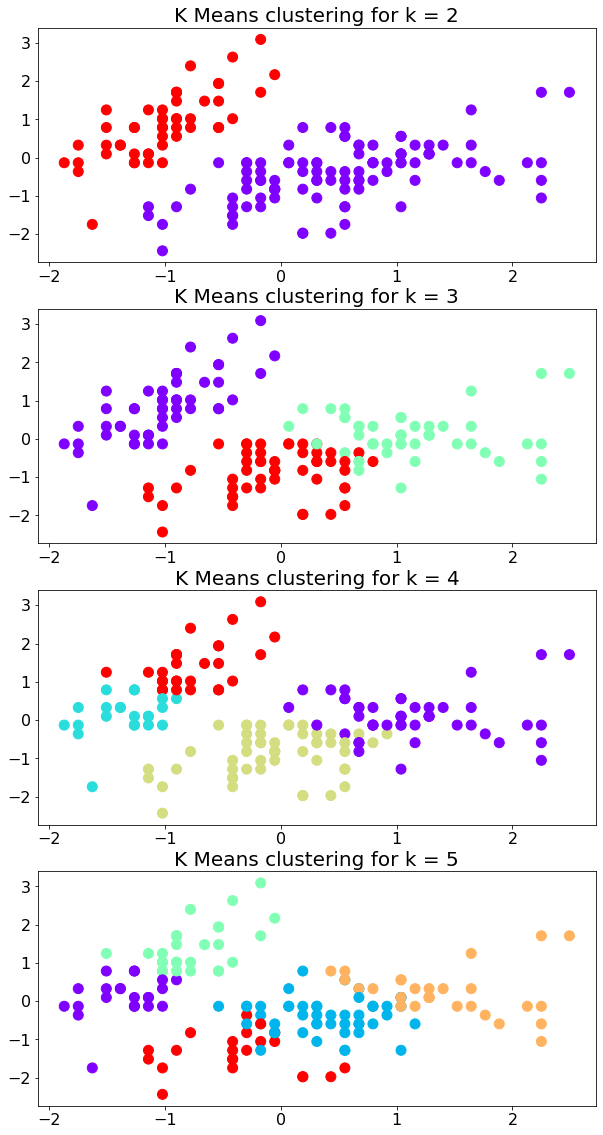

In [23]:
fig = plt.figure(figsize=(10, 25))
for i in range(2,6):
    kM = KMeans(n_clusters=i)
    pred = kM.fit_predict(X)
    acc_KM(X,labels_true, pred)
    
    # Plot the clusters
    plt.subplot(5, 1, i)
    plt.scatter(X[:,0],X[:,1],c=pred,cmap='rainbow',s = 100)
    plt.title(f'K Means clustering for k = {i}', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

### DBSCAN

In [24]:
def dbscan(X,eps,min_samples,labels_true):
    
    # Compute DBSCAN
    db = DBSCAN(eps = eps, metric = 'euclidean', min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # Homogeneity
    hmgnty = metrics.homogeneity_score(labels_true, labels)
    print('Homogeneity = ', hmgnty)
    
    # Completeness
    cmpltnss = metrics.completeness_score(labels_true, labels)
    print('Completeness = ', cmpltnss)
    
    # V-measure
    vmeasr = metrics.v_measure_score(labels_true, labels)
    print('V_measure = ', vmeasr)
    
    # Adjusted Rand Index
    adjrnd = metrics.adjusted_rand_score(labels_true, labels)
    print('Adjusted rand = ', adjrnd)
    
    # Adjusted Mutual Information
    mutinfo = metrics.adjusted_mutual_info_score(labels_true, labels)
    print('Adjusted Mutual Information',mutinfo)
    
    # Silhouette
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

### Plot Function

In [25]:
def dbscan_plot(X,eps, min_samples):
    
    # DBscan fit
    db = DBSCAN(eps = eps, metric = 'euclidean', min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # mask
    co = np.zeros_like(db.labels_, dtype=bool)
    co[db.core_sample_indices_] = True
    
    # unique lables
    unqlbl = set(labels)
    
    # number of clusters
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Color for each cluster
    colors = [plt.cm.autumn(l) for l in np.linspace(0, 1, len(unqlbl))]
       
    fig = plt.figure(figsize=(15, 10))
    
    # Plot
    for i, j in zip(unqlbl, colors):
        if i == -1:
            # Black used for noise.
            j = [0, 0, 0, 1]

        cl = (labels == i)

        xy = X[cl & co]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(j), markersize=15, markeredgecolor='k')

        xy = X[cl & ~co]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(j), markersize=7, markeredgecolor='k')

    plt.title('Number of clusters: %d' % n_clusters_)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

### - DBscan is highly sensetive to the parameter changes

### eps = 0.5 & min_samples = 5

In [26]:
dbscan(X,0.5,5,labels_true)

Homogeneity =  0.8512995739151626
Completeness =  0.5152467544782672
V_measure =  0.6419531243616023
Adjusted rand =  0.5776117248835163
Adjusted Mutual Information 0.5120984371481392
Silhouette Coefficient: 0.357


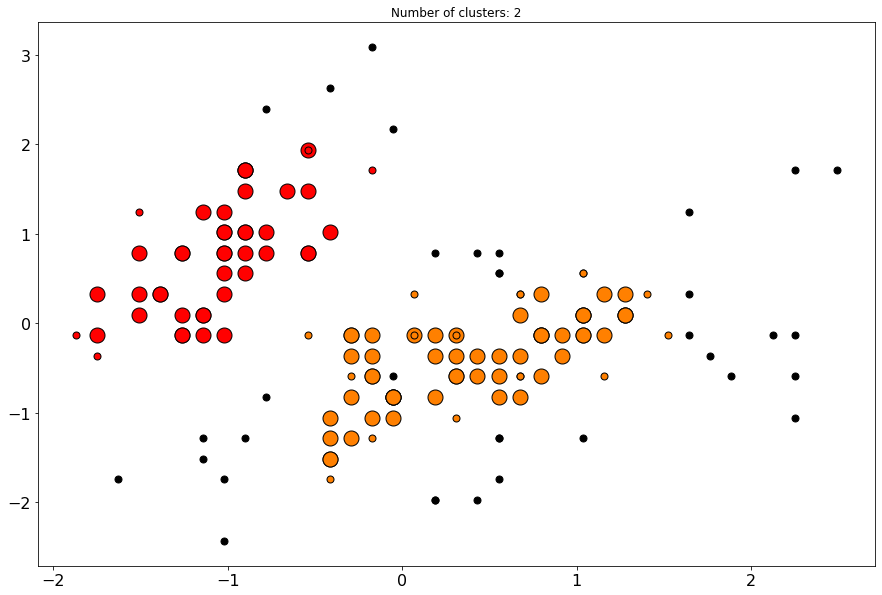

In [27]:
dbscan_plot(X,0.5,5)

### eps = 0.5 & min_samples = 10

In [28]:
dbscan(X,0.5,10,labels_true)

Homogeneity =  0.6123829524324834
Completeness =  0.36881693536697574
V_measure =  0.4603694040235978
Adjusted rand =  0.3954840674277786
Adjusted Mutual Information 0.36248386050904124
Silhouette Coefficient: 0.009


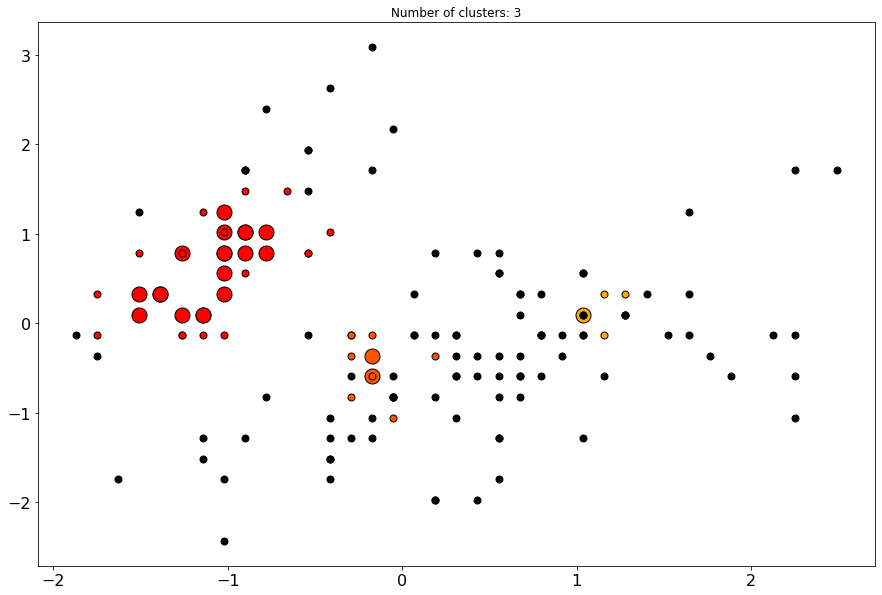

In [29]:
dbscan_plot(X,0.5,10)

### eps = 0.5 & min_samples = 15

In [30]:
dbscan(X,0.5,15,labels_true)

Homogeneity =  0.3118022161722811
Completeness =  0.46322221060663404
V_measure =  0.3727204120459885
Adjusted rand =  0.37423802431999165
Adjusted Mutual Information 0.3080761120607102
Silhouette Coefficient: 0.263


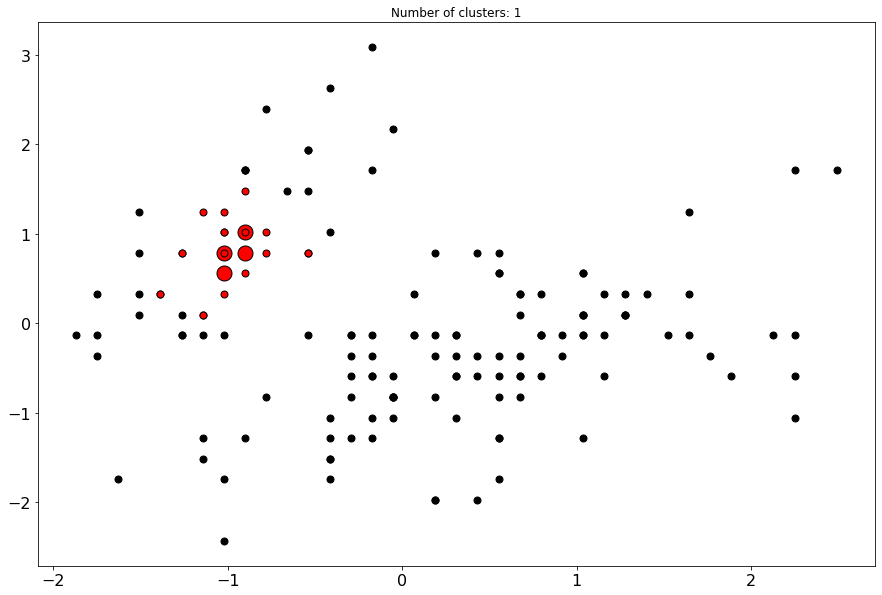

In [31]:
dbscan_plot(X,0.5,15)

### eps = 0.6 & min_samples = 5

In [32]:
dbscan(X,0.6,5,labels_true)

Homogeneity =  0.8830882419046074
Completeness =  0.5585828616885348
V_measure =  0.6843141352520054
Adjusted rand =  0.6522195835570632
Adjusted Mutual Information 0.5555784619450685
Silhouette Coefficient: 0.403


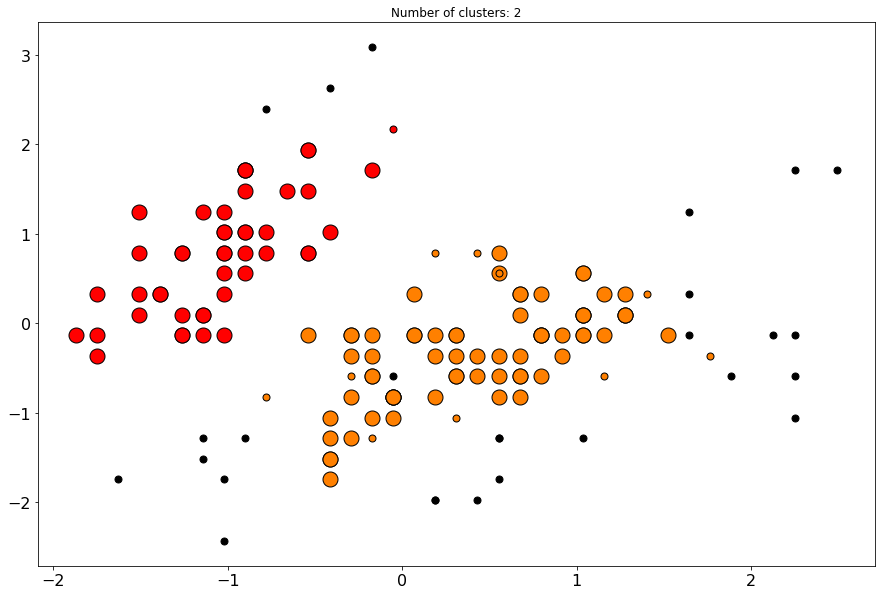

In [33]:
dbscan_plot(X,0.6,5)

### eps = 0.8 & min_samples = 5

In [34]:
dbscan(X,0.8,5,labels_true)

Homogeneity =  0.9764410525272769
Completeness =  0.8353447946505866
V_measure =  0.9003988542932103
Adjusted rand =  0.9383222324535097
Adjusted Mutual Information 0.8336732193898768
Silhouette Coefficient: 0.522


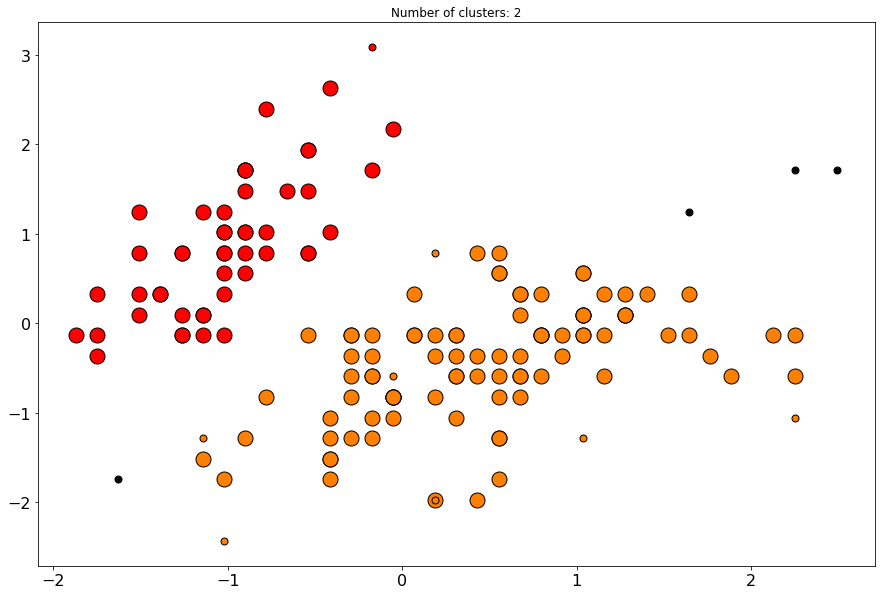

In [35]:
dbscan_plot(X,0.8,5)

### Dataset with different densities

(array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 8 Text yticklabel objects>)

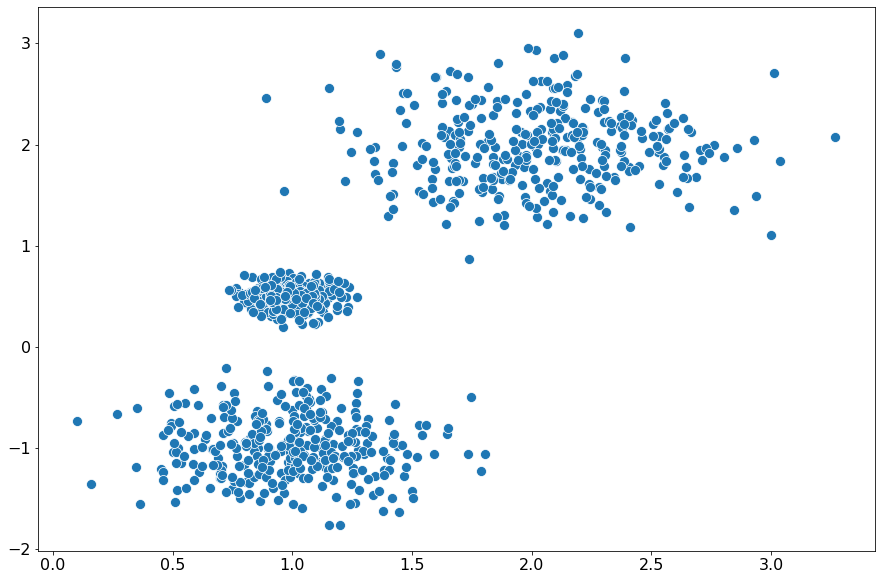

In [36]:
centers = [[1, 0.5], [2, 2], [1, -1]]
stds = [0.1, 0.4, 0.3]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(X[:,0], X[:,1],s=100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### - DBScan doesn’t properly work well over clusters with different densities

#### DBSCAN

In [37]:
dbscan(X,0.2,105,labels_true)

Homogeneity =  0.5798004017665548
Completeness =  1.0
V_measure =  0.7340172861308478
Adjusted rand =  0.5716725949351892
Adjusted Mutual Information 0.5794166739487981
Silhouette Coefficient: 0.219


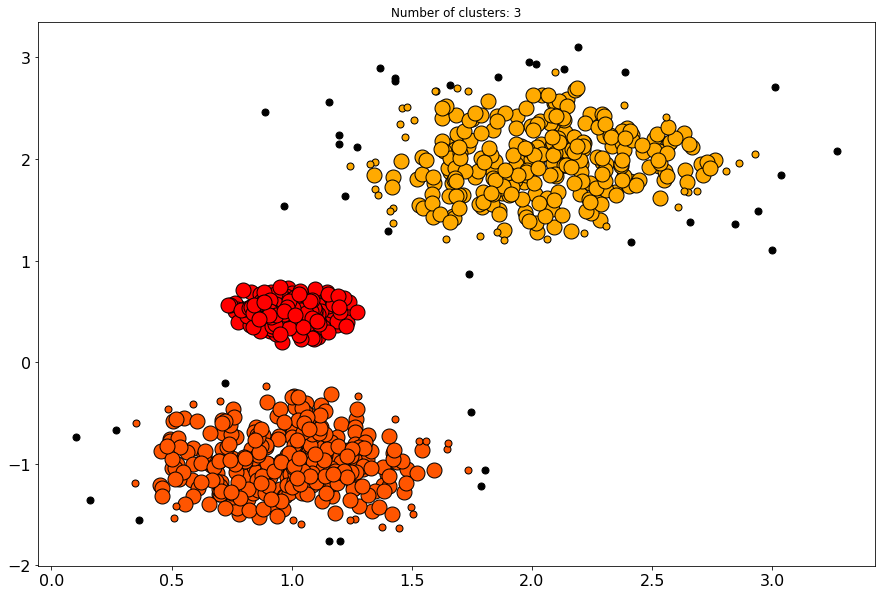

In [38]:
dbscan_plot(X,0.2,10)

### - K-Means algorithm is sensitive towards outlier. Outliers can skew the clusters in K-Means in very large extent.

#### K-Means

Homogeneity =  0.973229099486702
Completeness =  0.9732927133746077
V_measure =  0.9732609053911786
Adjusted rand =  0.9849945164155571
Adjusted Mutual Information 0.9731801435837537
Silhouette Coefficient: 0.712
---------------------------------------------------


(array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 <a list of 8 Text yticklabel objects>)

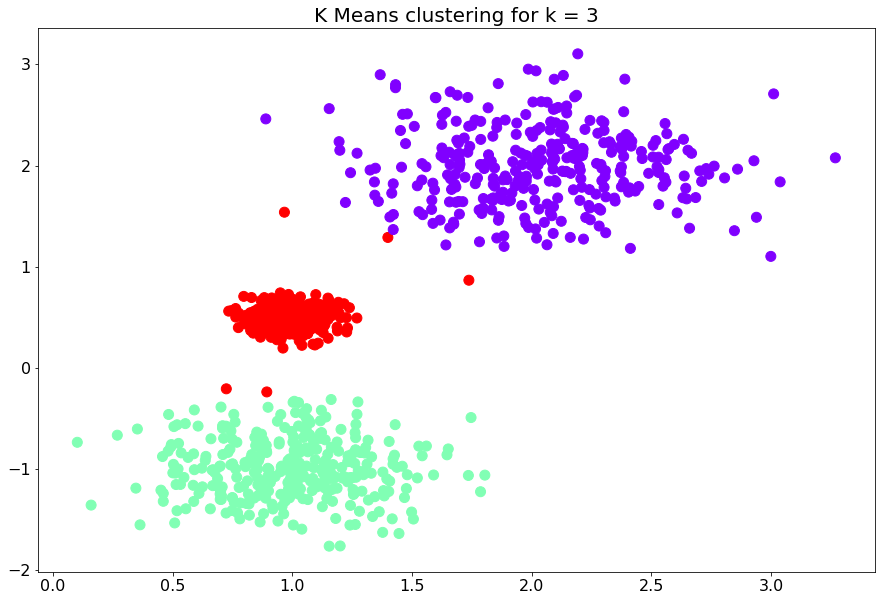

In [39]:
fig = plt.figure(figsize=(15, 10))
kM = KMeans(n_clusters=3)
pred = kM.fit_predict(X)
acc_KM(X,labels_true, pred)
    
# Plot the clusters
plt.scatter(X[:,0],X[:,1],c=pred,cmap='rainbow',s = 100)
plt.title(f'K Means clustering for k = 3', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 6.

### Elbow Method

Elbow shows the number of clusters (n) based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. The elbow of the n-SSE plot reveals the optimum number of clusters.

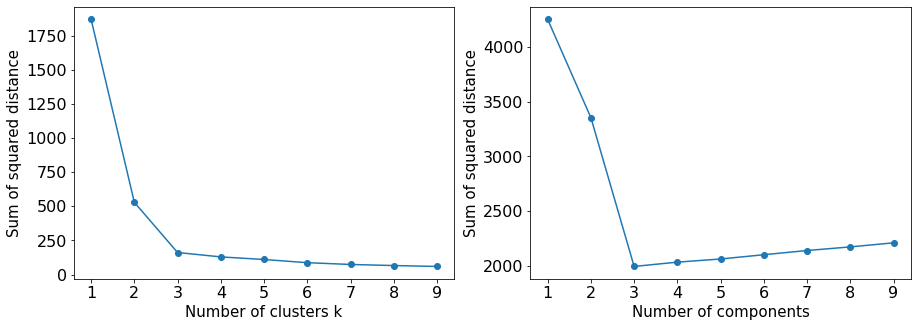

In [40]:
# Run the Kmeans algorithm and get the index of data points clusters
sse_kmean = []
sse_gmm = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k).fit(X)
    sse_kmean.append(km.inertia_)
    gmm = GaussianMixture(n_components=k).fit(X)
    sse_gmm.append(gmm.bic(X))
    
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(list_k, sse_kmean, '-o')
plt.xlabel(r'Number of clusters k',fontsize=15)
plt.ylabel('Sum of squared distance',fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(list_k, sse_gmm, '-o')
plt.xlabel(r'Number of components',fontsize=15)
plt.ylabel('Sum of squared distance',fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

For k-means we are looking for the elbow (here 3) and for the gaussian mixture we are looking for the minimum (here 3).

### Silhouette Analysis

Silhouette analysis is another method to estimate the number of clusters. For each sample we compute the average distance from all data points in the same cluster ($dr_i$), and then the average distance from all data points in the closest cluster ($dc_i$).
The number of clusters for which the coefficient $\frac{dc_i-dr_i}{max(dr_i,dc_i)}\$ is close to 1 we would have good estimate.

### Silhouette samples function for K-Means

In [41]:
def KMeans_silhouette(X,n_clusters):
    for i in range(2,n_clusters+1):
        labels = KMeans(n_clusters = i).fit_predict(X)
        silhouette_values = silhouette_samples(X, labels)
        plot_silhouette(X, labels, silhouette_values)

### Silhouette samples function for GMM

In [42]:
def GMM_silhouette(X,n_clusters):
    for i in range(2,n_clusters+1):
        labels = GaussianMixture(n_components = i).fit_predict(X)
        silhouette_values = silhouette_samples(X, labels)
        plot_silhouette(X, labels, silhouette_values)

### Silhouette Plot function

In [43]:
def plot_silhouette(X, labels, silhouette_values):
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=[15,5])
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_values = silhouette_values[labels == cluster]
        cluster_silhouette_values.sort()
        y_upper += len(cluster_silhouette_values)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_values, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_values)
    
    avg_score = np.mean(silhouette_values)
    ax1.axvline(avg_score, linestyle='--', linewidth=4, color='red')
    ax1.set_title('Silhouette Plot', y=1.02,fontsize=20);
    
    ax2.scatter(X[:, 0], X[:, 1], c=labels)
    ax2.set_title('Cluster Plot', y=1.02,fontsize=20)
    plt.show()

### K-Means results for k from 2 to 6

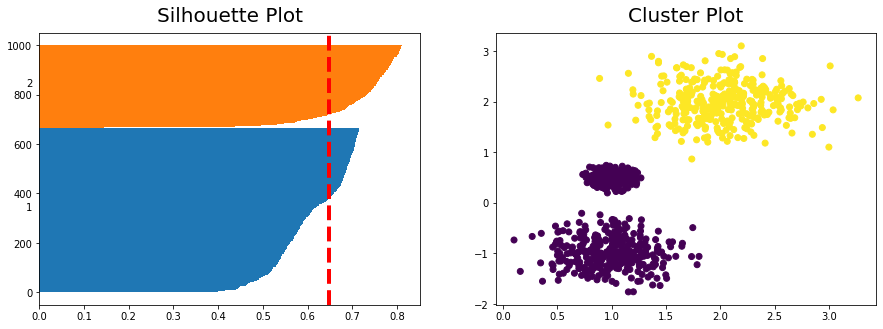

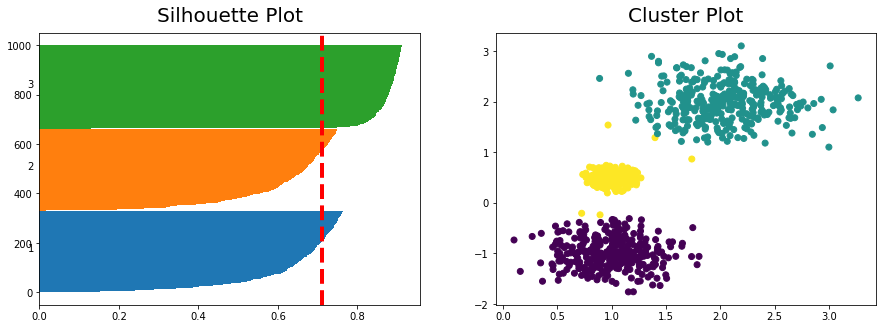

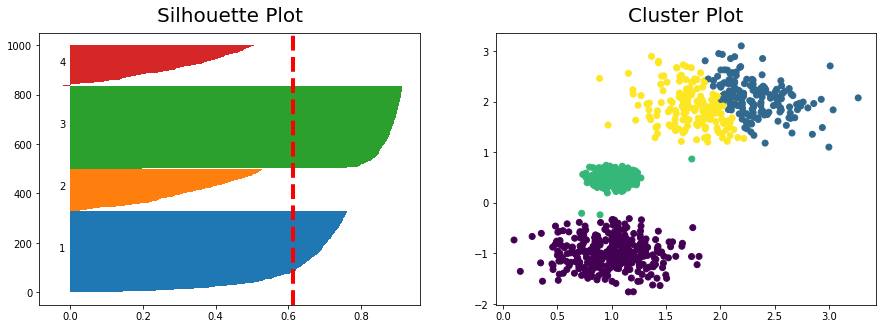

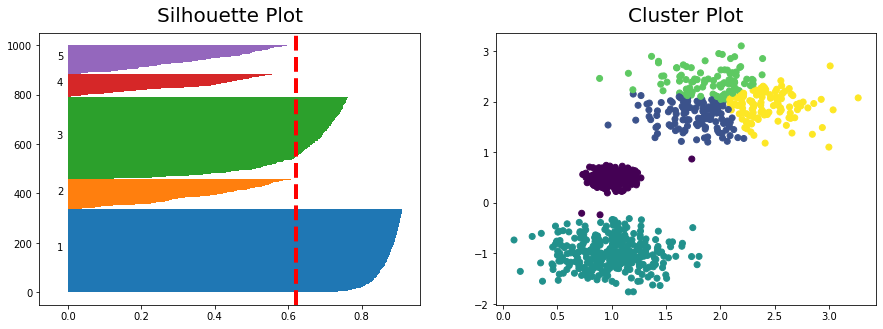

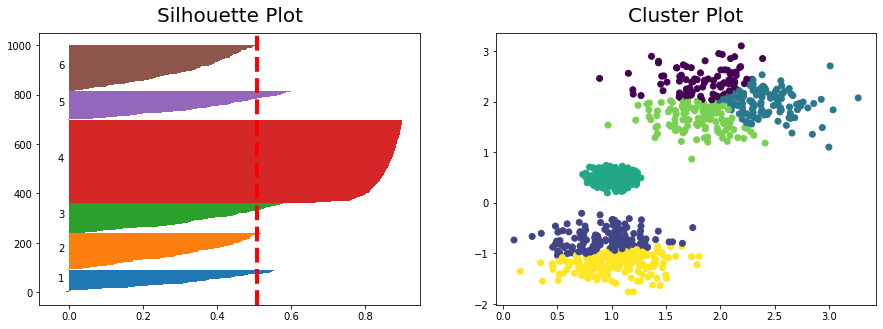

In [44]:
KMeans_silhouette(X,6)

According to the silhouette score and the plot thickness, it seems that number of cluster value of 3 is a good pick for the given data. Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 1 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 2 sub clusters into one big cluster. However when the n_clusters is equal to 3, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right. This the same for GMM silhouette plot too, where 3 clusters seem reasonable answer.

### GMM results for number of components from 2 to 6

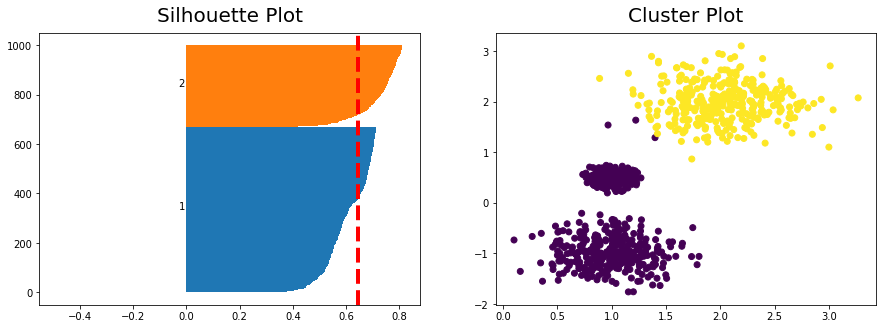

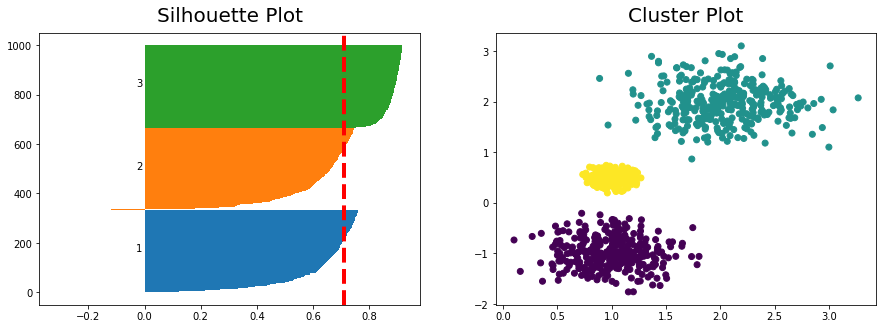

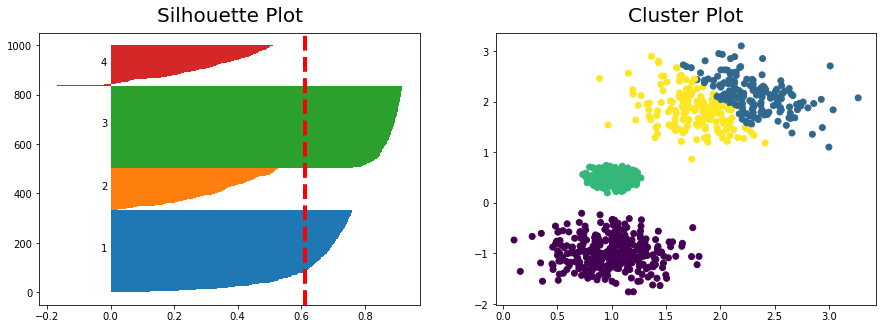

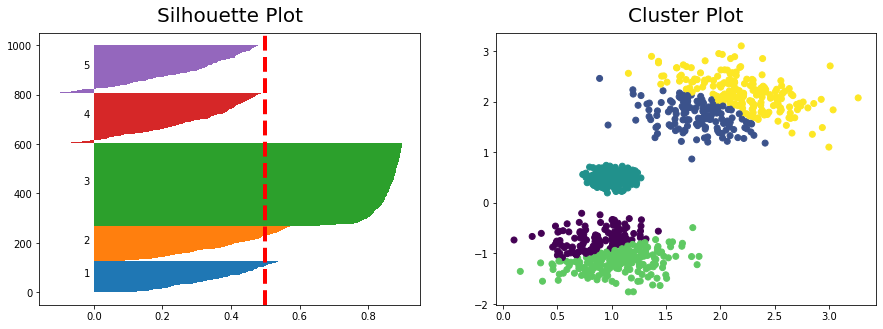

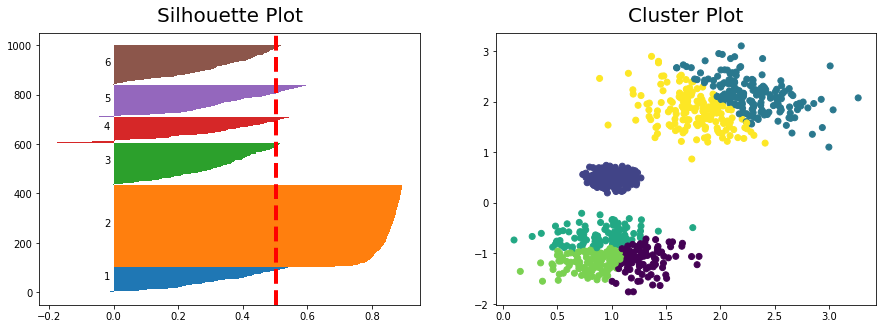

In [45]:
GMM_silhouette(X,6)

# 7.

# Complete Linkage

In [46]:
def dist(cls1,cls2):
    far_dist = -np.inf
    # for each point in each cluster
    for row1 in cls1:
        for row2 in cls2:
            # make sure that our furthest distance holds the maximum distance betweeen the clusters at focus
            if far_dist < distance.euclidean(row1,row2):
                far_dist = distance.euclidean(row1,row2)
    return far_dist

In [47]:
def complete_linkage(cls ,n_cls):
    while (len(cls)-n_cls != 0):
        # Clustering
        close_dist = np.inf
        clust_1 = clust_2 = None
        # for every cluster (until second last element)
        for id1, cls1 in enumerate(cls[:len(cls)]): 
            for id2, cls2 in enumerate(cls[(id1 + 1):]):
                far_dist = dist(cls1,cls2)
                if far_dist < close_dist:
                    clust_1 = id1
                    clust_2 = id1 + id2 + 1
                    close_dist = far_dist
               # extend just appends the contents to the list without flattening it out
        cls[clust_1].extend(cls[clust_2]) 
        # don't need this index anymore, and we have just clustered once more
        cls.pop(clust_2) 
    return cls

In [48]:
def hierarchical(df, n_cls):
    d = df.values
    init = []
    for row in d:
        init.append([row.tolist()])
    return complete_linkage(init, n_cls)

In [49]:
data = pd.read_csv('data_mvnorm2mix.csv',names=['x0', 'x1'])
X_train, X_test= train_test_split(np.array(data),  test_size=0.1, random_state=1234)
df = pd.DataFrame(X_test,columns=['x0', 'x1'])

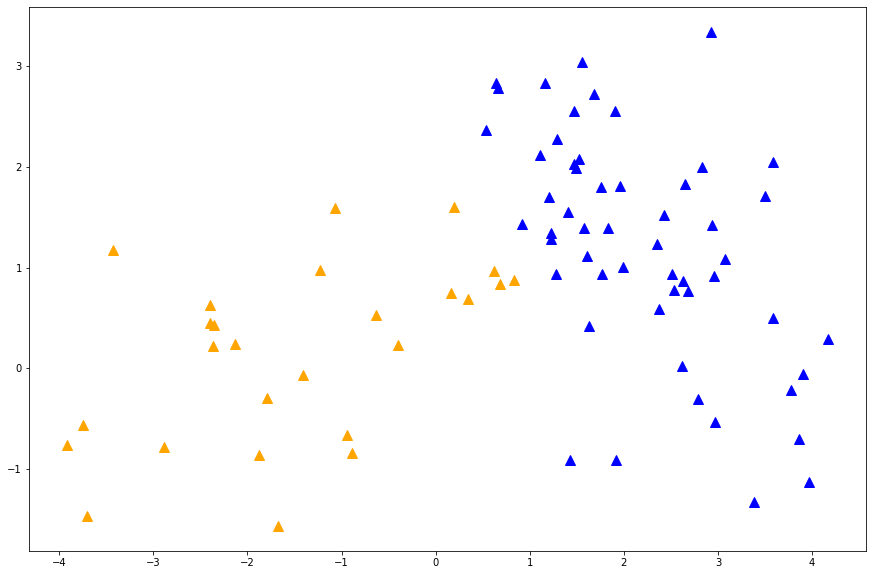

In [50]:
clusters = hierarchical(df,2)
colors = ['orange', 'blue']
plt.figure(figsize=(15,10))
for cluster_index, cluster in enumerate(clusters):
    for point in cluster:
        plt.plot([point[0]], [point[1]], marker='^', markersize=10, color=colors[cluster_index])

### References

https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 